In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data = pd.read_csv('NonGaussian_noise.csv', header = None)

In [4]:
x = np.array(data[[0]])
t = np.array(data[[1]])

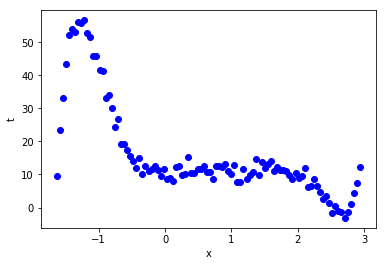

In [5]:
plt.figure()
plt.scatter(x,t, c='b')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [6]:
def moore_penrose(phi,lambd=0):
    temp = np.linalg.inv(lambd*np.identity(phi.shape[1]) + np.dot(phi.T, phi))
    mpi = np.dot(temp, phi.T)
    return mpi

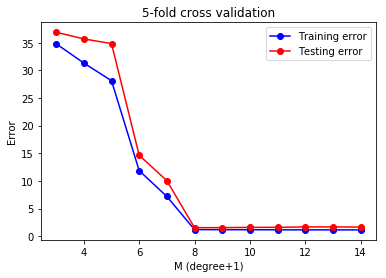

In [15]:
# 5 fold cross validation for M

data_shuffled = np.concatenate([x,t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
for i in range(3,15):
    tr_e = 0
    te_e = 0
    for j in range(5):
        train = np.concatenate([data_shuffled[:j*20], data_shuffled[(j+1)*20:]])
        test = data_shuffled[j*20 : (j+1)*20]
        x_train = train[:,0]
        t_train = train[:,1]
        x_test = test[:,0]
        t_test = test[:,1]
        
        design_matrix_train = np.zeros((80,i))
        for a in range(80):
            for b in range(i):
                design_matrix_train[a,b] = x_train[a]**b
                
        design_matrix_test = np.zeros((20,i))
        for a in range(20):
            for b in range(i):
                design_matrix_test[a,b] = x_test[a]**b
               
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += 0.5 * (np.sum(np.square(y_mp_train - t_train))) / 80
        te_e += 0.5 * (np.sum(np.square(y_mp_test - t_test))) / 20
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = np.arange(3,15)
plt.plot(xa,train_err,'-ob', label = "Training error")
plt.plot(xa,test_err,'-or', label = "Testing error")
plt.xlabel('M (degree+1)')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.show()

In [8]:
N = 100 
M = 8     # degree + 1
design_matrix = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        design_matrix[i,j] = x[i]**(j)

In [9]:
from math import ceil

def plot_error(err_list):
    xa = np.linspace(1,len(err_list),len(err_list),dtype=int)
    plt.figure()
    plt.plot(xa,err_list)
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('Gradient Descent')
    plt.show()

def gradient_descent(phi, labels, learning_rate, batch_size, iterations, M, lambd = 0, err_func = "mse"):
    w = np.zeros((M,1))
    num_batches = ceil(phi.shape[0]/batch_size)
    print("Number of batches = ",num_batches)
    err_list = []
    for i in range(iterations):
        for j in range(num_batches):
            batch_phi = phi[j*batch_size:(j+1)*batch_size][:]
            batch_labels = labels[j*batch_size:(j+1)*batch_size]
            
            y = np.dot(batch_phi,w)
            if err_func is "mse":
                err = 0.5 * (np.sum(np.square(y - batch_labels)) + lambd*np.sum(np.square(w))) / batch_size
                grad = (np.dot(batch_phi.T,(y - batch_labels)) + lambd*w) / batch_size
            if err_func is "mae":
                sgn = np.sign(y - batch_labels)
                err = np.sum(np.abs(y - batch_labels)) / batch_size
                grad = np.sum((batch_phi*sgn).T, axis = 1) / batch_size
                grad = grad.reshape((M,1))
            w = w - learning_rate*grad
            err_list.append(err)
    plot_error(err_list)
    print("Final gradient descent error (" + err_func + ") =",err_list[-1])
    return w

def linear_regression(phi,labels):
    lambd = 0
    
    w_moore = np.dot(moore_penrose(phi,lambd), labels)
    
    learning_rate = 1e-6  
    batch_size = 100
    iterations = 5000    
    err_func = "mse"
    w_grad = gradient_descent(phi, labels, learning_rate, batch_size, iterations, M, lambd, err_func)
    
    return [w_moore, w_grad]

Number of batches =  1


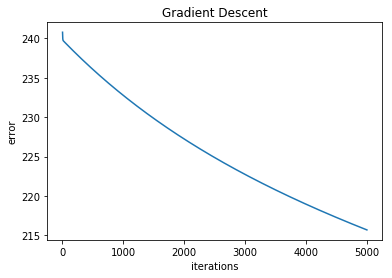

Final gradient descent error (mse) = 215.69939727968088


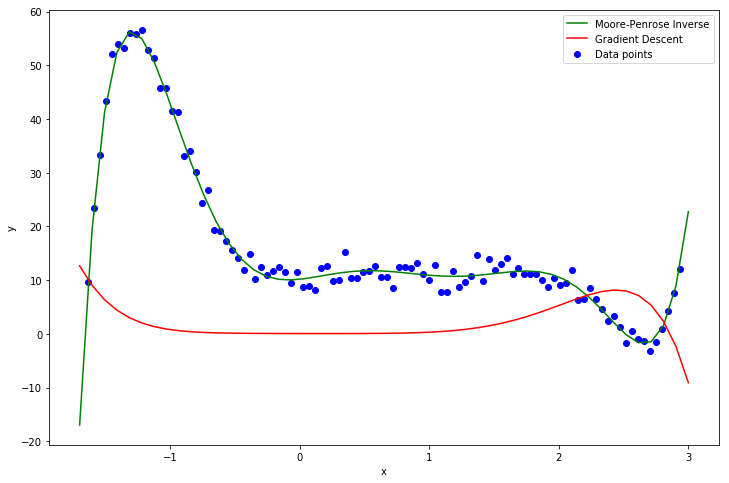

In [10]:
# def poly(x,w):
#    y = 0
#    for i in range(len(w)):
#        y += w[i]*(x**i)
#    return y

w_moore,w_grad = linear_regression(design_matrix[:N,:],t[:N]) 

xa = np.linspace(-1.7,3,50)
plt.figure(figsize = (12,8))
plt.scatter(x[:N],t[:N], c='b', label = 'Data points')
plt.plot(xa,np.polyval(w_moore[::-1],xa), c = 'g', label = 'Moore-Penrose Inverse')
plt.plot(xa,np.polyval(w_grad[::-1],xa), c = 'r', label = 'Gradient Descent')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [11]:
print(w_moore.T)
print(w_grad.T)

[[ 10.17680178   2.61146157  10.83312397 -26.3265299   11.70227874
    6.74583736  -5.87708132   1.0586828 ]]
[[ 0.07399004 -0.03174185  0.08665094 -0.0436866   0.14191756 -0.07448594
   0.25882564 -0.08721391]]


In [12]:
print("moore-penrose error =",0.5 * (np.sum(np.square(np.dot(design_matrix,w_moore) - t))) / N)
print("gradient descent error =",0.5 * (np.sum(np.square(np.dot(design_matrix,w_grad) - t))) / N)

moore-penrose error = 1.2386071007880113
gradient descent error = 215.69633746001952


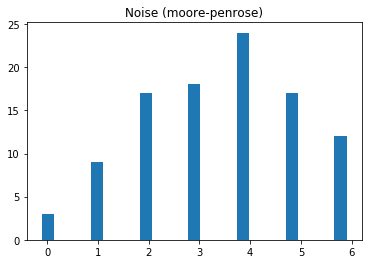

In [84]:
noise_g = np.dot(design_matrix,w_grad) - t
noise_m = np.dot(design_matrix,w_moore) - t
noise = noise_m - min(noise_m) - 1.37
#noise = noise/(max(noise))

plt.figure()
plt.hist(0.9+np.round(noise), bins=25)
plt.title('Noise (moore-penrose)')
plt.show()

In [78]:
print("Mean of noise =", np.mean(noise-1.37))
print("Variance of noise =", np.var(noise))

Mean of noise = 2.4729590813483884
Variance of noise = 2.4772142015760226


In [1]:
noise = noise_m-min(noise_m)+0.5
#plt.hist(noise,bins=20)


import scipy
import scipy.stats as stats
x_ = np.linspace(0,10,20)
y_ = 1+60*stats.gamma.pdf(x_,a=np.mean(noise)**2/np.var(noise),scale=(1/(np.mean(noise)/np.var(noise))))
#plt.plot(x_,y_)
#plt.plot(x_,y__)
plt.hist(np.log(noise),bins=30)
plt.show()

NameError: name 'noise_m' is not defined

In [94]:
np.mean(noise)/np.var(noise) #lambda

1.5513228847563805

In [95]:
np.mean(noise)**2/np.var(noise) #r

5.961670368078114

In [78]:
print(np.mean(noise),np.var(noise))

4.842959081348389 2.4772142015760226
